In [1]:
import pandas as pd
import numpy as np


import ihc_evaluation_functions

# IHC Test Set Evaluation

     This dataset contains IHC attributed customer journey test sets of four different conversion types. Training set for each conversion type and test sets can be generated by running the notebook "IHC 2 - Training Set Generation"

In [3]:
## importing the data
df_eval = pd.read_csv("datasets/cj_evaluated.csv")
df_eval.head()

,conversion_id,session_id,timestamp,channel_label,holder_engagement,closer_engagement,conversion,initializer,holder,closer,ihc,initializer_redist,holder_redist,closer_redist,ihc_redist,market,customer_status
0,b5455601a5,6f248ba6a7b27d85a599,2021-04-04 23:34:51,Shopping - Non Brand,0,0,0,1.0,0.0000,0.0000,0.3310,1.0,0.0000,0.0,0.331,NL,new
1,b5455601a5,c37d81c07c8656907024,2021-04-04 23:36:18,SEO,1,0,0,0.0,0.4322,0.0000,0.1634,0.0,0.5317,0.0,0.201,NL,new
2,b5455601a5,aa3ddaf73f8c6064bce9,2021-04-04 23:39:17,Shopping - Non Brand,1,1,0,0.0,0.3807,0.2776,0.2247,0.0,0.4683,1.0,0.468,NL,new
3,b5455601a5,d98f8e5b45ee011db2d7,2021-04-05 09:32:30,Direct,1,1,1,0.0,0.1871,0.7224,0.2809,0.0,0.0000,0.0,0.000,NL,new
4,12c7fb69ef,ee500aae2f2c0347c2b6,2020-12-26 12:54:39,Social Paid,0,0,0,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.000,NL,new


# About the Dataset

     In the first notebook we choose only one conversion type for IHC Webservice Parameter Training, which was new customers in NL Market. In the second notebook we computed the IHC Attribution results of the test set that we created with the training set. This notebook will be about evaluating those results on the channel level. 

In [4]:
df_eval.pivot_table(columns=["customer_status"], index=["market"], aggfunc="nunique", values = "conversion_id")

customer_status,new,return
market,,
DE,3000,3000
NL,3000,3000


In [5]:
## grouping dataset by conversion types
grouped = df_eval.groupby(["market", "customer_status"])
grouped.groups.keys()

dict_keys([('DE', 'new'), ('DE', 'return'), ('NL', 'new'), ('NL', 'return')])

     If you train the conversion type in the IHC Webservice and compute the IHC Attribution results of the test set, you should also get the same results with the dataset above.
    
     In addition to the conversion type "new customers, NL market", you can find the attribution results of 3 other conversion types. Since we used this conversion type in the first two notebooks, I selected the same conversion as default, but of course, you can freely choose different types and run the notebook to see how differentiate evaluation results between different conversion types.

In [6]:
## now for the simplicity lets choose one conversion type and continue with it
df_nl_new = grouped.get_group(("NL", 'new'))

# Evaluation Without Redistribution

          As you may have noticed, we have a parameter called redistribution, that helps to reallocate given credits from non-significant channels to the others. In the first part of the evaluation I will show the results which computed without using the redistribution parameter. At the end you can see a comparison table, that shows the effect of redistribution clearly.

In [7]:
df_nl_new.head()

,conversion_id,session_id,timestamp,channel_label,holder_engagement,closer_engagement,conversion,initializer,holder,closer,ihc,initializer_redist,holder_redist,closer_redist,ihc_redist,market,customer_status
0,b5455601a5,6f248ba6a7b27d85a599,2021-04-04 23:34:51,Shopping - Non Brand,0,0,0,1.0,0.0000,0.0000,0.3310,1.0,0.0000,0.0,0.331,NL,new
1,b5455601a5,c37d81c07c8656907024,2021-04-04 23:36:18,SEO,1,0,0,0.0,0.4322,0.0000,0.1634,0.0,0.5317,0.0,0.201,NL,new
2,b5455601a5,aa3ddaf73f8c6064bce9,2021-04-04 23:39:17,Shopping - Non Brand,1,1,0,0.0,0.3807,0.2776,0.2247,0.0,0.4683,1.0,0.468,NL,new
3,b5455601a5,d98f8e5b45ee011db2d7,2021-04-05 09:32:30,Direct,1,1,1,0.0,0.1871,0.7224,0.2809,0.0,0.0000,0.0,0.000,NL,new
4,12c7fb69ef,ee500aae2f2c0347c2b6,2020-12-26 12:54:39,Social Paid,0,0,0,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.000,NL,new


## IHC Attribution Table

     This table gives us initial insights to the evaluation results. We saw the feature "Influenced Conversions" before in the IHC training set generation notebook. For the recap, it was the number of unique conversions, which has at least one session with this channel. Another important feature is the "Attributed Conversions". It is the sum of aggregated attributed conversions per channel, in this case it shows combined IHC value. 
     
     The last feature, average attribution impact is nothing but attributed conversions divided by influenced conversions. Since the other two features heavaliy depend on the distribution of the channels in a dataset, this feature allows us to compare channels.

In [8]:
#Creating Contribution Table
df_cont = df_nl_new.groupby("channel_label").agg(
            Influenced_Conv = ("conversion_id", "nunique"),
            Attributed_Conv = ("ihc", "sum" ), 
)


df_cont["Influenced_Conv_%"] = df_cont.Influenced_Conv/df_cont.Influenced_Conv.sum()
df_cont["Attributed_Conv_%"] = df_cont.Attributed_Conv/df_cont.Attributed_Conv.sum()
df_cont["Avg_Attribution_Impact"] =  df_cont.Attributed_Conv/df_cont.Influenced_Conv

#Rendering the table
col_order = ['Influenced_Conv', "Influenced_Conv_%", "Attributed_Conv", "Attributed_Conv_%", "Avg_Attribution_Impact"]
df_cont[col_order].sort_values("Attributed_Conv", ascending = False)\
                  .round(3)\
                  .style.background_gradient("Greens")\
                  .format(formatter = "{:.3f}")

,Influenced_Conv,Influenced_Conv_%,Attributed_Conv,Attributed_Conv_%,Avg_Attribution_Impact
channel_label,,,,,
Shopping - Non Brand,1775.000,0.172,692.156,0.231,0.390
Direct,1789.000,0.174,602.935,0.201,0.337
SEO,1797.000,0.175,471.582,0.157,0.262
SEA - Brand,1150.000,0.112,318.132,0.106,0.277
Email,826.000,0.080,246.317,0.082,0.298
Social Paid,708.000,0.069,200.377,0.067,0.283
SEA - Non Brand,782.000,0.076,160.855,0.054,0.206
Referral,718.000,0.070,145.588,0.049,0.203
Affiliate,242.000,0.024,59.992,0.020,0.248


## IHC Channel Scores and IHC Attribution Value Distribution

### Channel Scores

     Here you can see the calculation of IHC Channel Scores. It is calculated in two steps. Firstly, we have to find each channel's IHC Share, which is aggregated individual initializer, holder and closer values divided by combined IHC  value for each channel. The second step is dividing each of IHC phase values to their mean. It gives us how strong a certain channel is in a certain phase when compared to other channels and other IHC phases.

In [9]:
## Computation of IHC Shares
ihc_cols = ["initializer", "holder", "closer", 'ihc']
ihc_shares =  df_nl_new.groupby("channel_label")[ihc_cols].sum()\
                     .sort_values("ihc", ascending = False)\
                     .apply(lambda x: x/x.ihc, axis =1).iloc[:7,:3]


## IHC Scores
ihc_scores = ihc_shares/ihc_shares.mean()
ihc_scores

,initializer,holder,closer
channel_label,,,
Shopping - Non Brand,1.050681,1.065113,0.850391
Direct,0.800246,1.012649,1.235723
SEO,0.808768,1.053901,1.170723
SEA - Brand,1.171352,0.970195,0.822684
Email,0.769751,1.033831,1.246409
Social Paid,1.302472,0.852674,0.811575
SEA - Non Brand,1.096730,1.011635,0.862496


     With the help of bar plots, we can visualize the IHC Channel Scores to see the relationships in a better way.

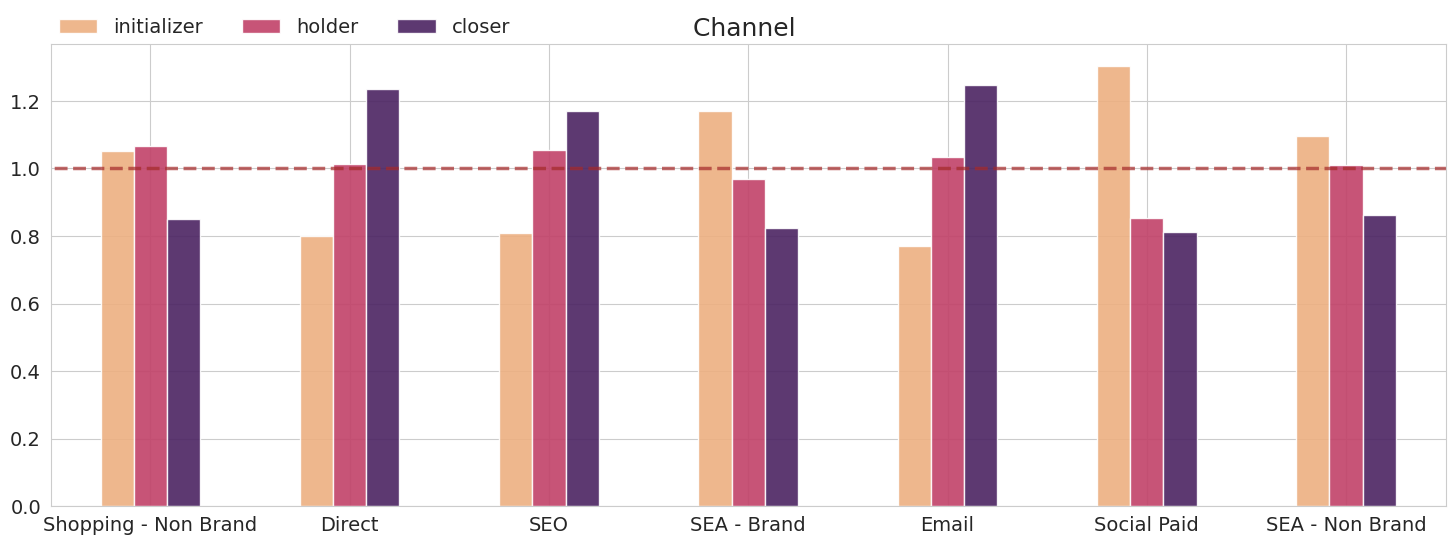

In [12]:
fig = ihc_evaluation_functions.plot_ihc_scores(ihc_scores)
fig

### IHC Attributed Value Distribution per Channel

     It is also interesting to see the distribution of Combined IHC Values per channel by using histograms and kernel density estimation. 
     Here I plotted them for the channels Shopping Non Brand and Social Paid. Despite the similarities like the lack of values between 0.7 and 0.9 or the majority of the values is being very close to 0, we can also see some differences between distributions.

In [34]:
## defining channel and IHC value to plot
CHANNEL = ["Shopping - Non Brand", "Social Paid"]
IHC = "ihc"

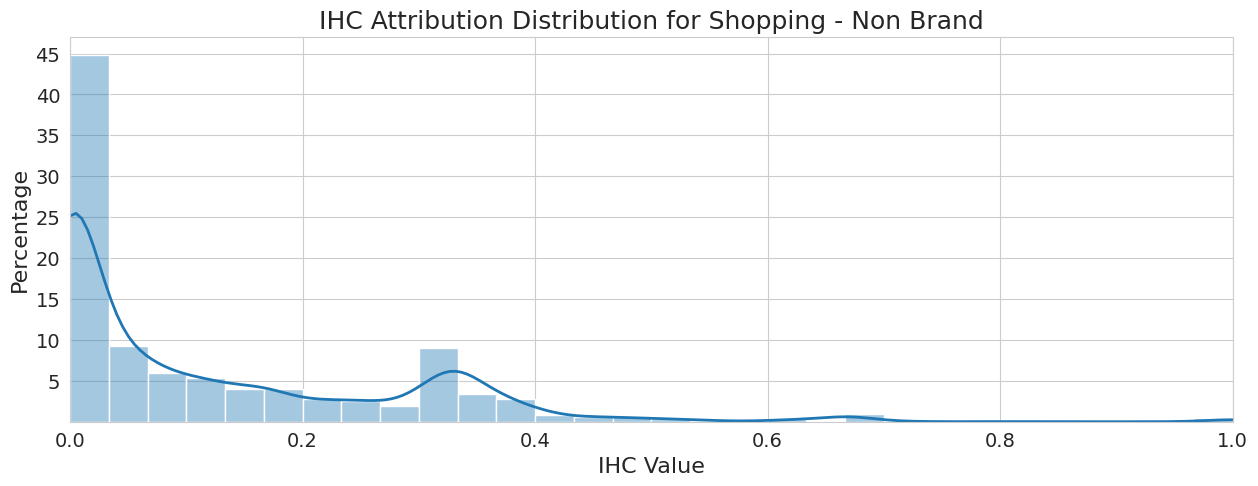

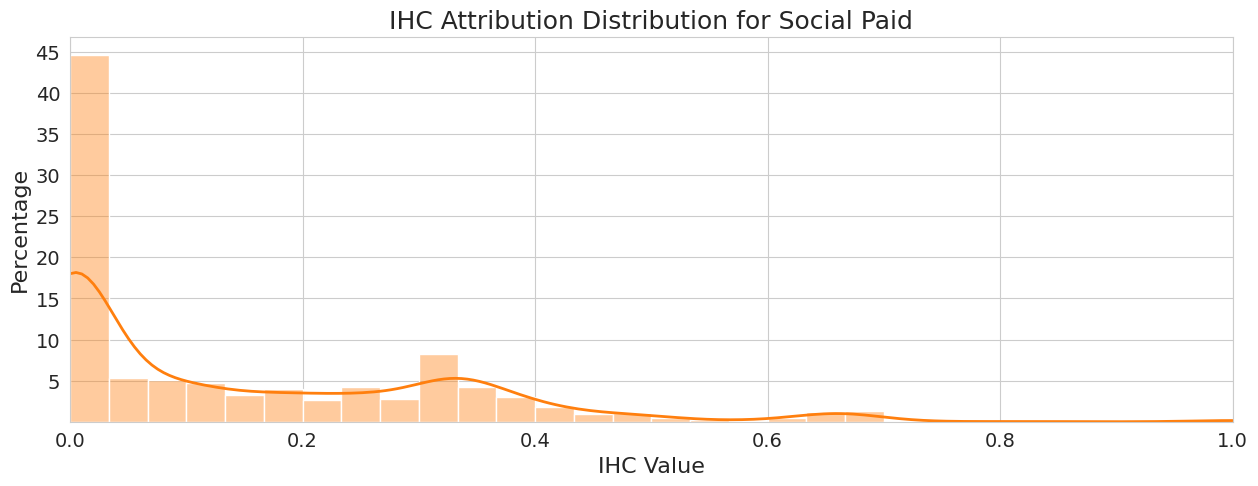

In [35]:
for channel in CHANNEL:
    ihc_evaluation_functions.attribution_distribution(df_nl_new, channel, IHC, True)

## IHC Model in Comparison to Other Attribution Models

     Before going with the redistribution, I want to evaluate my test set with other most known models, so that we can see how the results differ model to model. I want to use First Click, Last Click, U-Shape, and Time Decay model for this part. You can take a look at the functions for those models in the "c" script that has been imported at the beginning, 

In [37]:
## class that contains attribution models as methods
AttributionCompute = ihc_evaluation_functions.AttributionModels(df_nl_new, 'timestamp', "conversion_id")
models = AttributionCompute.get_models()
models

['model_first_click', 'model_last_click', 'model_time_decay', 'model_u_shape']

In [38]:
## attributing the conversions for those for models
df_nl_new = AttributionCompute.apply_models(*models)

In [39]:
df_nl_new.head()

,conversion_id,session_id,timestamp,channel_label,holder_engagement,closer_engagement,conversion,initializer,holder,closer,...,initializer_redist,holder_redist,closer_redist,ihc_redist,market,customer_status,model_first_click,model_last_click,model_time_decay,model_u_shape
0,b5455601a5,6f248ba6a7b27d85a599,2021-04-04 23:34:51,Shopping - Non Brand,0,0,0,1.0,0.0000,0.0000,...,1.0,0.0000,0.0,0.331,NL,new,1,0,0.000000,0.4
1,b5455601a5,c37d81c07c8656907024,2021-04-04 23:36:18,SEO,1,0,0,0.0,0.4322,0.0000,...,0.0,0.5317,0.0,0.201,NL,new,0,0,0.002403,0.1
2,b5455601a5,aa3ddaf73f8c6064bce9,2021-04-04 23:39:17,Shopping - Non Brand,1,1,0,0.0,0.3807,0.2776,...,0.0,0.4683,1.0,0.468,NL,new,0,0,0.007346,0.1
3,b5455601a5,d98f8e5b45ee011db2d7,2021-04-05 09:32:30,Direct,1,1,1,0.0,0.1871,0.7224,...,0.0,0.0000,0.0,0.000,NL,new,0,1,0.990252,0.4
4,12c7fb69ef,ee500aae2f2c0347c2b6,2020-12-26 12:54:39,Social Paid,0,0,0,0.0,0.0000,0.0000,...,0.0,0.0000,0.0,0.000,NL,new,1,0,0.000000,0.4


     Lets create table with aggregated attribution results per channel for each model

In [40]:
#Creating aggregated attribution table for each model
df_cont_2 = df_nl_new.groupby("channel_label").agg(
            Influenced_Conv = ("conversion_id", "nunique"),
            Attributed_I = ("initializer", "sum" ),
            Attributed_H = ("holder", "sum" ),
            Attributed_C = ("closer", "sum" ),
            Attributed_IHC = ("ihc", "sum" ),

            First_Click = ("model_first_click", "sum"),
            Last_Click = ("model_last_click", "sum"),
            Time_Decay = ("model_time_decay", "sum"),
            U_Shape = ("model_u_shape", "sum"),

)

#Attribution table in percentages and impact table 
df_cont_2_perc = df_cont_2.apply(lambda x: x/x.sum())
df_cont_2_impact = df_cont_2/df_cont_2.Influenced_Conv.values.reshape(-1,1)



     Now we are able to see side by side how other models are attributing the conversions throughout the customer journeys in comparison to the IHC Attribution. Lets have a look at the percentage distribution of attributed conversions among the channels.

In [41]:
# Contribution Table in Percentages
(100*df_cont_2_perc).sort_values("Attributed_IHC", ascending = False)\
              .style\
              .background_gradient("Reds")\
              .format(formatter = "% {:.2f}")

,Influenced_Conv,Attributed_I,Attributed_H,Attributed_C,Attributed_IHC,First_Click,Last_Click,Time_Decay,U_Shape
channel_label,,,,,,,,,
Shopping - Non Brand,% 17.24,% 25.86,% 23.89,% 18.84,% 23.07,% 26.63,% 16.87,% 20.99,% 22.44
Direct,% 17.38,% 17.16,% 19.78,% 23.85,% 20.10,% 14.13,% 25.23,% 23.81,% 19.82
SEO,% 17.46,% 13.56,% 16.10,% 17.68,% 15.72,% 15.80,% 19.37,% 15.41,% 17.17
SEA - Brand,% 11.17,% 13.25,% 10.00,% 8.38,% 10.60,% 14.03,% 7.43,% 8.41,% 10.29
Email,% 8.02,% 6.74,% 8.25,% 9.83,% 8.21,% 5.90,% 11.23,% 9.25,% 8.31
Social Paid,% 6.88,% 9.28,% 5.54,% 5.21,% 6.68,% 9.57,% 3.03,% 5.84,% 6.39
SEA - Non Brand,% 7.60,% 6.27,% 5.27,% 4.44,% 5.36,% 7.20,% 3.97,% 4.93,% 5.59
Referral,% 6.98,% 1.20,% 6.19,% 7.27,% 4.85,% 1.13,% 9.13,% 6.06,% 5.08
Affiliate,% 2.35,% 2.04,% 2.06,% 1.87,% 2.00,% 2.13,% 1.83,% 2.03,% 2.01


     As you may have noticed, U-Shape and combined IHC results are quite similar when we aggregate them by channel. Lets have a deeper look at them now to understand whether are they identical in terms of distribution of credits or not.
     To identify differences between two models, firstly, I want to see how results are looking like when we aggregate separately the First and teh Last Touchpoints from Mid Touchpoints. 

In [42]:
# First and Last Touchpoints
df_fl = df_nl_new[df_nl_new.model_u_shape == 0.4].groupby("channel_label").agg({"ihc":"sum", "model_u_shape":"sum"}).sort_values("ihc", ascending = False)
# Mid Touchpoints
df_m = df_nl_new[df_nl_new.model_u_shape != 0.4].groupby("channel_label").agg({"ihc":"sum", "model_u_shape":"sum"}).sort_values("ihc", ascending = False)

     It is interesting to see that, even though the aggregated attributed conversions per channel are similar between the two models on the top level, on the customer level, these models are distributing given credits in totally different ways. 
     As we can see in the table below, the U-Shape model attributes conversions among the first and the last touchpoints more than it needs to be. We can say similar things for mid touchpoints as well, it seems like the U-Shape model under-attributes the conversions.

In [43]:
# Concetanate
df_concat = pd.concat([df_fl, df_m], keys = ["First and Last Touchpoint", "Mid Touchpoints"], axis =1)
df_concat[[('All Touchpoints', "ihc"), ('All Touchpoints', 'u_shape')]] = df_concat.groupby(axis = 1, level= 1).sum()
# Table
df_concat.sort_values(("All Touchpoints", "ihc"), ascending = False)\
              .style\
              .background_gradient("Greens")\
              .format(formatter = "{:.2f}")

         As we did above, plotting the distributions of the attributed conversion results also helps us to understand how models behave. Here I plotted histograms of the U-Shape results and combined IHC results together for Shopping Non Brand channel. 

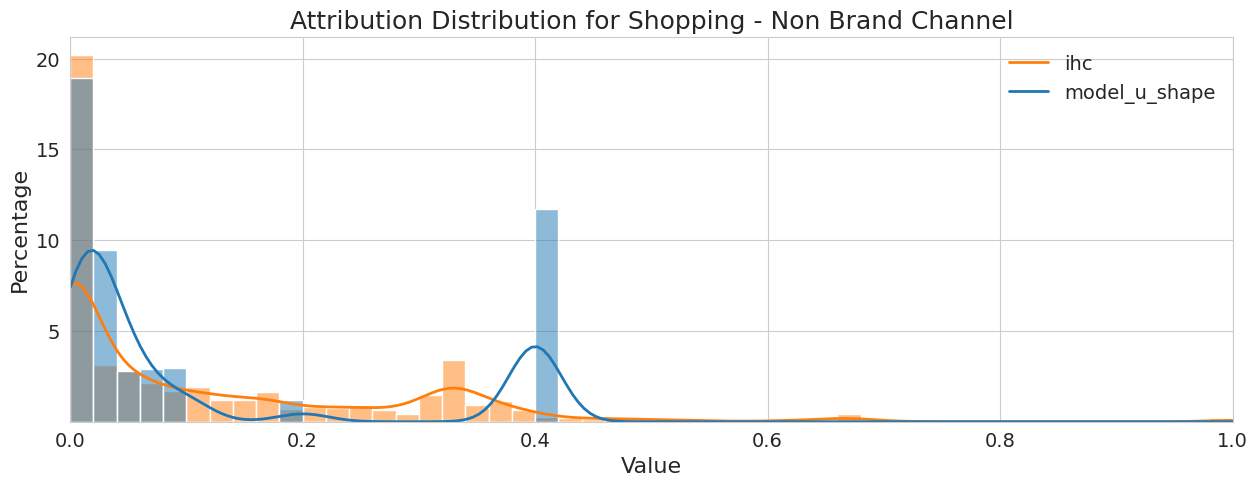

In [45]:
models = ['model_u_shape', 'ihc']
ihc_evaluation_functions.attribution_distribution_compare(df_nl_new, "Shopping - Non Brand", *models)

     Lastly, this is the distribution of the differences in results between the combined IHC and U-Shape model at the session level for the same channel. We can easily understand why they are similar when we aggregate them by looking at this plot. The shape of the distribution is more or less symetrical around zero; that's why when we summed them up, the total difference between the two models does not land too far away from zero.

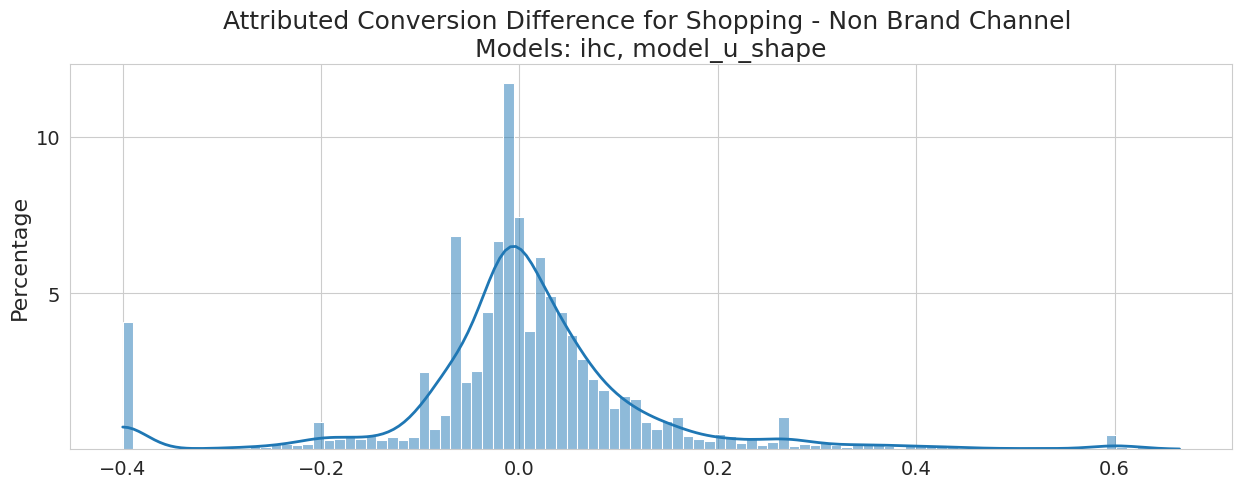

In [47]:
ihc_evaluation_functions.attribution_distribution_difference(df_nl_new, "Shopping - Non Brand", 
                                                     'ihc', 'model_u_shape', show_nb  = False)

## Redistribution Effect on Channel Contribution

     While evaluating of the test sets according to the trained model, we have the opportunity to set a redistribution parameter and get redistributed IHC Attribution results. It redistributes partially or fully the Attribution results of channels we wanted to the other channels. I placed the parameter inside the "get_task" function in the notebook "IHC 3 - Api Request" and assigned a boolean value to control it. However, we can re-adjust and re-write it when it is necessary.

              redistribution_parameter = {
                                'initializer' : {
                                    'direction' : 'earlier_sessions_only',
                                    'receive_threshold' : 0.01,
                                    'redistribution_channel_labels' : ["Direct"],
                                },
                                'holder' : {
                                    'direction' : 'any_session',
                                    'receive_threshold' : 0.01,
                                    'redistribution_channel_labels' :  [ "Direct"],
                                },
                                'closer' : {
                                    'direction' : "any_session",
                                    'receive_threshold' : 0.01,
                                    'redistribution_channel_labels' : [ "Direct"],
                                }
            }
            


     "direction" parameter can take three values. They are "earlier_sessions_only", "later_sessions_only" or "any_sessions"
     
     "receive_threshold" should be in the interval [0,1]. 0 means no threshhold, so full redistribution. And the value 0.01 indicates partially distribution.
     
     "redistribution_channel_labels" is the list of channels we want to redistribute. Please make sure to write exact same labels as in your data set in string format

In [48]:
## selecting columns 
ihc_cols = ["initializer", "holder", "closer", "ihc"]
ihc_cols_redist = ["initializer_redist", "holder_redist", "closer_redist", "ihc_redist"]

## channel contribution tables
ch_contr_wredist = df_nl_new.groupby("channel_label")[ihc_cols]\
                                    .sum().apply(lambda x: 100*x/x.sum())\
                                    .sort_values("ihc", ascending = False)\
                                    .round(3)

ch_contr_redist = df_nl_new.groupby("channel_label")[ihc_cols_redist]\
                                 .sum().apply(lambda x: 100*x/x.sum())\
                                 .rename({k:v for k,v in zip(ihc_cols_redist, ihc_cols)}, axis =1)\
                                 .sort_values("ihc", ascending = False)\
                                 .round(3).loc[ch_contr_wredist.index.values]
## difference between two dataframes
ch_contr_diff = (ch_contr_redist-ch_contr_wredist).loc[ch_contr_wredist.index]

## concatenating dataframes for rendering
df_comparison = pd.concat((ch_contr_wredist, ch_contr_redist,ch_contr_diff ), axis = 1, keys = ["Without Redistribution", "With Redistribution", "Difference"])

     Here we can see how the redistribution parameter affects on the distribution of the results. In this case "Direct Traffic" channel's Attribution Results were partially redistributed.

In [49]:
df_comparison.sort_values(("Without Redistribution", "ihc"), ascending = False)\
              .style\
              .background_gradient("Reds", subset = ["Without Redistribution", "With Redistribution"])\
              .background_gradient("Greens", subset = "Difference")\
              .format(formatter = "% {:.2f}")